In [ ]:
import datetime
import gc
import os
import warnings
warnings.filterwarnings("ignore")
import random
from collections import defaultdict
from tqdm import tqdm

import catboost
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from catboost import Pool, cv
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import KFold, train_test_split
from torch.utils.data import RandomSampler


from dataclasses import dataclass

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


%matplotlib inline
path_dir=os.getcwd()
path_train='../train_dataset_train.csv'
path_test='./test_dataset_test.csv'
path_subm='./Иннополис/sample_solution.csv'

@dataclass
class Config:
    RS: int = 42
    treshold: float = 0.0
    device='cuda:0'
    num_epochs: int = 120
    batch_size: int = 256
    num_workers: int = 2

In [ ]:
def get_df(path,train=True):
    df=pd.read_csv(path)
    df=df.sort_index(axis=1)
    df.drop(['id','.geo','area'],axis=1,inplace=True)
    if train:
        df=df.loc[df.crop.isin([0,4])]
        y=df[['crop']]
        df.drop(['crop'],axis=1,inplace=True)  
    
    df.rename({c:pd.to_datetime(c.replace('nd_mean_','')) for c in df.columns},axis=1,inplace=True) 
    df[df<=0]=0    
    return (df.reset_index(drop=True).values,y.crop.reset_index(drop=True).values) if train else df.reset_index(drop=True).values

In [3]:
params_model={
    #'auto_class_weights': 'Balanced',
    #'loss_function':'MultiClass',
   # 'boosting_type': 'Ordered',
   # 'thread_count': -1,   
    #'loss_function': 'MultiClassOneVsAll',
    'loss_function':'Logloss',
    'random_seed':42,
    #'task_type':'GPU',
    #'eval_metric': 'TotalF1:average=Macro',#'MCC',#PRAUC:type=OneVsAll;use_weights=True
    'eval_metric':'Recall',
    #'cat_features':list(df_train_cat),    
    'bootstrap_type':'Bayesian',#'Bernoulli',#'Poisson',
    #'subsample':0.44,  #  ?????????? TRY TO TUNE THIS
    'l2_leaf_reg': 3,
    'early_stopping_rounds':20,
    'iterations':200,         
     'verbose':20,
    'depth': 5, 'learning_rate': 0.07,#####################################
 #'learning_rate':0.3,
#'bagging_temperature':0,
 #'depth':7,
 #'save_snapshot':True,
 #'snapshot_file':os.path.join(path_chkpts,f'shapshot_more_rem{version}.bkp'),
 #'snapshot_interval':100,
 #'border_count':254,
 #'per_float_feature_quantization':'2:border_count=1024'

}

In [4]:
params_grid  = {
          #'subsample':np.arange(0.4,0.54,0.02),
          'learning_rate': [0.07,0.2,0.4],          
          'depth':  [4,5,6,7,8],
        }
params_cv = {
    #'X':df_train_rolling,
#     'X':X_train,#df_train.ewm(alpha=0.3,axis=0).mean(),
#     'y':y_train,
    'cv':5,
    'shuffle':True,
    'stratified':True,
    #'return_models':True,
}
#grid_search_catbost=model_catboost.randomized_search(param_distributions=params_grid,**params_cv)

In [5]:
def seed_everything(seed=42):
    random.seed(seed)    
    np.random.seed(seed)
seed_everything()



X_train,y_train=get_df(path_train)
#columns=X_train.columns
FOLDS=5
kfolds = KFold(n_splits=FOLDS)

result={'recall':[],'cm':[],'epochs_loss':[]}

splits = kfolds.split(X_train,y_train)    
for train_index, valid_index in splits:    
    X_tr, X_val = X_train[train_index], X_train[valid_index]
    y_tr, y_val = y_train[train_index], y_train[valid_index]    

    train_pool = Pool(X_tr, y_tr)
    val_pool = Pool(X_val, y_val)

    model=catboost.CatBoostClassifier(**params_model)
    model.fit(train_pool)

    indices, scores = model.get_object_importance(
        val_pool,
        train_pool,
        importance_values_sign='Positive' # Negative, All
    )

#         labels,counts=np.unique(y_tr, return_counts=True)
#         _max=np.max(counts)*2
#         sampling_strategy={label:_max  for label in labels }#if label==0 else int(_max+_max*0.4)
#         smote = SMOTE(random_state=42, sampling_strategy=sampling_strategy, n_jobs=-1)  
#         X_tr, y_tr = smote.fit_resample(X_tr, y_tr)

    y_val_pred = model.predict(X_val)
    recall=recall_score(y_true=y_val,y_pred=y_val_pred,average='macro')
    cm=confusion_matrix(y_true=y_val,y_pred=y_val_pred)
    result['recall'].append(recall)
    result['cm'].append(cm)
    break
    

0:	learn: 0.8661017	total: 142ms	remaining: 28.2s
20:	learn: 0.9644068	total: 197ms	remaining: 1.68s
40:	learn: 0.9627119	total: 265ms	remaining: 1.03s
60:	learn: 0.9711864	total: 320ms	remaining: 728ms
80:	learn: 0.9830508	total: 376ms	remaining: 553ms
100:	learn: 0.9932203	total: 429ms	remaining: 421ms
120:	learn: 0.9949153	total: 486ms	remaining: 318ms
140:	learn: 0.9983051	total: 560ms	remaining: 235ms
160:	learn: 1.0000000	total: 619ms	remaining: 150ms
180:	learn: 1.0000000	total: 678ms	remaining: 71.1ms
199:	learn: 1.0000000	total: 731ms	remaining: 0us


In [6]:
result

{'recall': [0.9477144798136645],
 'cm': [array([[158,   3],
         [ 11, 117]], dtype=int64)],
 'epochs_loss': []}

In [7]:
res=pd.DataFrame({
    'indices':indices,
    'scores':scores,
})

<AxesSubplot: >

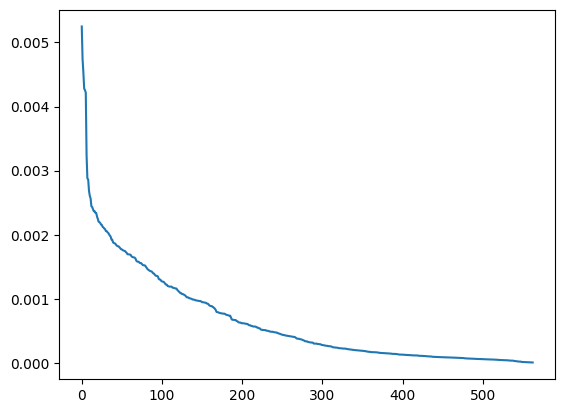

In [8]:
res.scores.plot()

In [9]:
res.tail(10)

,indices,scores
553,1087,0.000013
554,441,0.000013
555,754,0.000012
556,852,0.000012
557,900,0.000011
558,561,0.000011
559,932,0.000009
560,663,0.000009
561,781,0.000008
562,460,0.000008


In [10]:
indices.shape

AttributeError: 'list' object has no attribute 'shape'